# Kueski kaggle movie lens exercise
### Movie Lens Data Set

**Carlos Alberto Escobedo Lopez**



First things first, lets import the data set.

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('grouplens/movielens-20m-dataset')

import zipfile
with zipfile.ZipFile("movielens-20m-dataset.zip","r") as zip_ref:
    zip_ref.extractall('')
    
import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd

from datetime import datetime 

import matplotlib.pyplot as plt

import numpy as np

tag=pd.read_csv("tag.csv")

genome_tags=pd.read_csv("genome_tags.csv")    

movie=pd.read_csv("movie.csv")

rating=pd.read_csv("rating.csv")

genome_scores=pd.read_csv("genome_scores.csv")

df=pd.merge(rating,movie)

df=df.sample(n=50000)

# Merging

Aditional information stored in the secondary datasets will be added. 

In [3]:
genome=pd.merge(genome_scores,genome_tags)

tag=pd.merge(tag,movie,on="movieId")

tag=pd.merge(tag,genome_tags,how="left",on="tag")

tags_completos=pd.merge(tag,genome , how="left" , on=["movieId","tagId"])

tags_completos=tags_completos.iloc[:,:-1]

In [4]:
tags_completos.head()

,userId,movieId,tag_x,timestamp,title,genres,tagId,relevance
0,18,4141,Mark Waters,2009-04-24 18:19:40,Head Over Heels (2001),Comedy|Romance,NaN,NaN
1,66193,4141,naive,2011-01-08 00:22:10,Head Over Heels (2001),Comedy|Romance,NaN,NaN
2,70201,4141,Mark Waters,2011-06-17 17:53:44,Head Over Heels (2001),Comedy|Romance,NaN,NaN
3,89274,4141,Freddie Prinze Jr.,2013-07-30 06:01:35,Head Over Heels (2001),Comedy|Romance,NaN,NaN
4,65,208,dark hero,2013-05-10 01:41:18,Waterworld (1995),Action|Adventure|Sci-Fi,288.0,0.9495


# Feature engineering

Creating new variables using the **mean relevance and the count** of the tags given by the users to each movie. 

In [5]:
num_tags_vs_relevance=tags_completos.groupby(by=["userId","movieId"]).count()

num_tags_vs_relevance=num_tags_vs_relevance.iloc[:,0]

num_tags_vs_relevance=num_tags_vs_relevance.reset_index()

num_tags_vs_relevance.rename(columns={'tag_x': 'num_tags'}, inplace=True)

media=tags_completos.groupby(by=["userId","movieId"]).mean()

media=media.loc[:,"relevance"]

media=media.reset_index()
 
num_tags_vs_relevance=pd.merge(num_tags_vs_relevance,media, on=["userId","movieId"])

df=pd.merge(df,num_tags_vs_relevance, how="left" , on=["userId","movieId"]).sort_values(by="num_tags",ascending=False)

df["tags_relevance"]=df["num_tags"]*df["relevance"]


In [6]:
df.head()

,userId,movieId,rating,timestamp,title,genres,num_tags,relevance,tags_relevance
38397,58612,96610,4.0,2012-11-05 03:59:09,Looper (2012),Action|Crime|Sci-Fi,39.0,0.728071,28.394786
35480,130827,2503,3.0,2008-11-07 20:34:03,"Apple, The (Sib) (1998)",Drama,27.0,0.474208,12.803625
5772,58612,31921,3.5,2013-04-17 13:51:28,"Seven-Per-Cent Solution, The (1976)",Adventure|Comedy|Crime|Drama|Mystery|Thriller,25.0,NaN,NaN
19845,23982,5618,4.5,2011-12-20 16:05:19,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,15.0,0.803273,12.049091
38589,5063,60069,3.0,2009-07-01 21:50:53,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,13.0,0.839667,10.915667


The **genres** of the movies are also included, so extracting them and using them to build **categorical variables** is the logical next step. This will be one of the most important variables to predict wether a user rates a move as high or don't.

In [7]:
df=pd.concat([df,df.genres.str.get_dummies('|').add_prefix('genre_')],axis=1)

**Not all of the genres are relevant**, so we only will keep the first 10 most used, in order to reduce computing resources. 

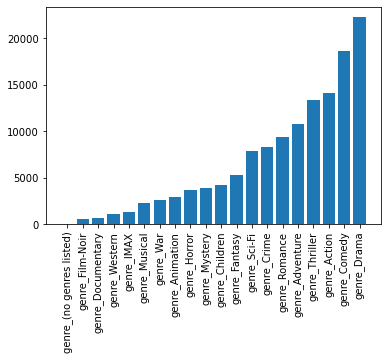

In [8]:
most_common_genres= df.loc[:,[col for col in df.columns if 'genre_' in col]].sum(axis = 0, skipna = True)

plt.bar(most_common_genres.sort_values().index,most_common_genres.sort_values(), )

plt.xticks(rotation='vertical')

plt.show()

In [9]:
drop=most_common_genres.drop(most_common_genres.sort_values(ascending=False).iloc[0:10].index)

df=df.drop(drop.index, axis=1)

In [10]:
df.head()

,userId,movieId,rating,timestamp,title,genres,num_tags,relevance,tags_relevance,genre_Action,genre_Adventure,genre_Children,genre_Comedy,genre_Crime,genre_Drama,genre_Fantasy,genre_Romance,genre_Sci-Fi,genre_Thriller
38397,58612,96610,4.0,2012-11-05 03:59:09,Looper (2012),Action|Crime|Sci-Fi,39.0,0.728071,28.394786,1,0,0,0,1,0,0,0,1,0
35480,130827,2503,3.0,2008-11-07 20:34:03,"Apple, The (Sib) (1998)",Drama,27.0,0.474208,12.803625,0,0,0,0,0,1,0,0,0,0
5772,58612,31921,3.5,2013-04-17 13:51:28,"Seven-Per-Cent Solution, The (1976)",Adventure|Comedy|Crime|Drama|Mystery|Thriller,25.0,NaN,NaN,0,1,0,1,1,1,0,0,0,1
19845,23982,5618,4.5,2011-12-20 16:05:19,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,15.0,0.803273,12.049091,0,1,0,0,0,0,1,0,0,0
38589,5063,60069,3.0,2009-07-01 21:50:53,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,13.0,0.839667,10.915667,0,1,1,0,0,0,0,1,1,0


Using **datetime fatures** as a variable is also a good option. **Not only the date related to the rating** given by the user, but also the **date when the film was released**. 

In [11]:
df["movie_year"]=df["title"].str[-5:-1]

df["movie_year"]=pd.to_numeric(df['movie_year'], errors = "coerce")

df["timestamp"]=pd.to_datetime(df["timestamp"])

df["year"]=df["timestamp"].dt.year

df["month"]=df["timestamp"].dt.month

df["day"]=df["timestamp"].dt.day

df["day_of_week"]=df["timestamp"].dt.day_name()

df=pd.concat([df,pd.get_dummies(df["day_of_week"])],axis=1)

In [12]:
df.head()

,userId,movieId,rating,timestamp,title,genres,num_tags,relevance,tags_relevance,genre_Action,...,month,day,day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
38397,58612,96610,4.0,2012-11-05 03:59:09,Looper (2012),Action|Crime|Sci-Fi,39.0,0.728071,28.394786,1,...,11,5,Monday,0,1,0,0,0,0,0
35480,130827,2503,3.0,2008-11-07 20:34:03,"Apple, The (Sib) (1998)",Drama,27.0,0.474208,12.803625,0,...,11,7,Friday,1,0,0,0,0,0,0
5772,58612,31921,3.5,2013-04-17 13:51:28,"Seven-Per-Cent Solution, The (1976)",Adventure|Comedy|Crime|Drama|Mystery|Thriller,25.0,NaN,NaN,0,...,4,17,Wednesday,0,0,0,0,0,0,1
19845,23982,5618,4.5,2011-12-20 16:05:19,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,15.0,0.803273,12.049091,0,...,12,20,Tuesday,0,0,0,0,0,1,0
38589,5063,60069,3.0,2009-07-01 21:50:53,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,13.0,0.839667,10.915667,0,...,7,1,Wednesday,0,0,0,0,0,0,1


# Preprocessing

In order to **avoid overfitting** problems, aditional steps such as **normalization** must be performed. Doing it directly over the df Dataframe would imply a possible source of **data leakage**. It is necessary to split first this Data Frame into the objective vector we want to predict, and the matrix of variables using to predict this vector. Next , we will split them into **train and test sets**. Finally, normalization will be implemented. 

In [13]:
X=df.drop(["timestamp","title","genres","day","day_of_week","rating"],axis=1)

Y=df["rating"]

Y=pd.DataFrame(Y)

Y["texto"]=pd.Series(['high_rate' if x >= 4 else 'low_rate' for x in Y.iloc[:,0]])

Y.loc[:,["high_rate","low_rate"]]=pd.get_dummies(Y["texto"])

Y=Y["high_rate"]

from sklearn.model_selection import train_test_split

X_train, X_test , Y_train, Y_test = train_test_split(X,Y, test_size=.1) 

In [14]:
Y.head()

38397    0
35480    0
5772     0
19845    0
38589    0
Name: high_rate, dtype: uint8

In [15]:
X_train.loc[:,"num_tags"].replace(np.nan, 0, inplace=True)
X_test.loc[:,"num_tags"].replace(np.nan, 0, inplace=True)

In [16]:
X_train.head()

,userId,movieId,num_tags,relevance,tags_relevance,genre_Action,genre_Adventure,genre_Children,genre_Comedy,genre_Crime,...,movie_year,year,month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
39290,22901,34338,0.0,NaN,NaN,0,0,0,1,0,...,2005.0,2006,2,0,0,0,1,0,0,0
39435,58232,1208,0.0,NaN,NaN,1,0,0,0,0,...,1979.0,1997,4,0,1,0,0,0,0,0
14511,14461,1547,0.0,NaN,NaN,0,0,1,0,0,...,1997.0,1997,12,1,0,0,0,0,0,0
35541,16707,2376,0.0,NaN,NaN,1,1,0,0,0,...,1985.0,2000,12,0,1,0,0,0,0,0
24884,2529,104,0.0,NaN,NaN,0,0,0,1,0,...,1996.0,2006,7,0,0,0,0,0,0,1


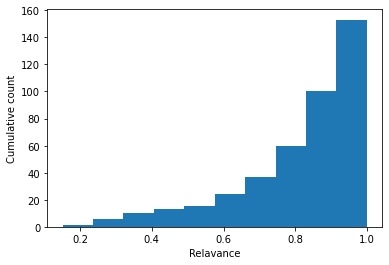

In [17]:
plt.hist(X_train["relevance"],cumulative=True)

plt.xlabel("Relavance")

plt.ylabel("Cumulative count")

plt.show()

In this case, replaciing with **median** instead of average is a better choice for null values of column relevance.

In [18]:
X_train.loc[:,"relevance"].replace(np.nan, X_train.loc[:,"relevance"].median(),inplace=True) 
X_test.loc[:,"relevance"].replace(np.nan, X_test.loc[:,"relevance"].median(),inplace=True)

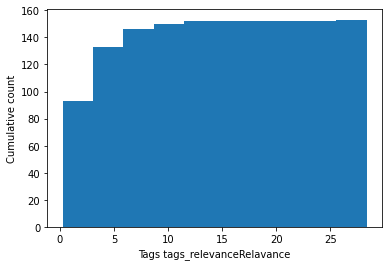

In [19]:
plt.hist(X_train["tags_relevance"],cumulative=True)

plt.xlabel("Tags tags_relevanceRelavance")

plt.ylabel("Cumulative count")

plt.show()

In [20]:
X_train.loc[:,"tags_relevance"].replace(np.nan, X_train.loc[:,"tags_relevance"].median(), inplace=True)
X_test.loc[:,"tags_relevance"].replace(np.nan, X_test.loc[:,"tags_relevance"].median(), inplace=True)

In [21]:
print(X_train.isnull().sum())

userId             0
movieId            0
num_tags           0
relevance          0
tags_relevance     0
genre_Action       0
genre_Adventure    0
genre_Children     0
genre_Comedy       0
genre_Crime        0
genre_Drama        0
genre_Fantasy      0
genre_Romance      0
genre_Sci-Fi       0
genre_Thriller     0
movie_year         1
year               0
month              0
Friday             0
Monday             0
Saturday           0
Sunday             0
Thursday           0
Tuesday            0
Wednesday          0
dtype: int64


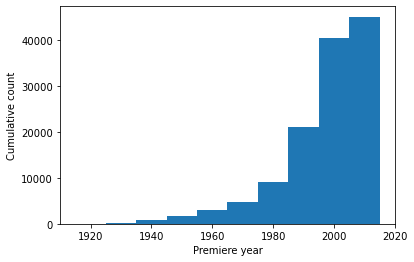

In [22]:
plt.hist(X_train["movie_year"],cumulative=True)

plt.xlabel("Premiere year")

plt.ylabel("Cumulative count")

plt.show()

In [23]:
X_train.loc[:,"movie_year"].replace(np.nan, X_train.loc[:,"movie_year"].median(), inplace=True)
X_test.loc[:,"movie_year"].replace(np.nan, X_test.loc[:,"movie_year"].median(), inplace=True)

Normalizing the rest of the variables

In [24]:
normalize=["userId","movieId","num_tags","movie_year","year","month","tags_relevance"]

X_train_norm=X_train[normalize]

from sklearn.preprocessing import StandardScaler

from sklearn_pandas import DataFrameMapper

scaler=StandardScaler()

mapper = DataFrameMapper([(X_train_norm.columns, scaler)])

scaled_features = mapper.fit_transform(X_train_norm.copy(), 4)

X_train_norm = pd.DataFrame(scaled_features, index=X_train_norm.index, columns=X_train_norm.columns)

X_test_norm=X_test[normalize]

scaler=StandardScaler()

mapper = DataFrameMapper([(X_test_norm.columns, scaler)])

scaled_features = mapper.fit_transform(X_test_norm.copy(), 4)

X_test_norm = pd.DataFrame(scaled_features, index=X_test_norm.index, columns=X_test_norm.columns)

In [25]:
X_train.drop(normalize, inplace=True, axis=1)   

X_train=pd.merge(X_train,X_train_norm, left_index=True, right_index=True)

X_test.drop(normalize, inplace=True, axis=1)   

X_test=pd.merge(X_test,X_test_norm, left_index=True, right_index=True)

# Training the model
Setting grid search for **hyper parameter tunning**

In [26]:
#from sklearn.model_selection import GridSearchCV

#import xgboost as xgb

#parameters=dict(learning_rate=[.01,.1,.5],n_estimators=[10,20,100,150],use_label_encoder =[False], max_depth=[1,10,20], subsample=[.1, .3, .5], min_child_weight=[.1,.6])

#XBG_GS=GridSearchCV(XBG,parameters,n_jobs=-1,scoring="accuracy") #Definiendo el operador de gridsearch.

#XBG_GS.fit(X_train,Y_train)


#print(XBG_GS.best_score_, XBG_GS.best_params_)

**Training** with the best set of parameters:

In [27]:
import xgboost as xgb

XBG=xgb.XGBClassifier(use_label_encoder =False,max_depth=10,subsample=.6,n_estimators=200,learning_rate=.01,min_child_weight=.6, eval_metric="aucpr")

XBG.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=0.6, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

# Model evaluation

As we are dealing with a **binary classification problem**, accuracy, precision and recall will be used to evaluate performance.  

In [28]:
#Train set

from sklearn.metrics import accuracy_score, precision_score, recall_score

Y_pred = XBG.predict(X_train)

predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(Y_train, predictions)

prec = precision_score(Y_train, predictions)

recall=recall_score(Y_train, predictions)

print("Precision_train: %.2f%%" % (prec * 100.0))

print("Accuracy_train: %.2f%%" % (accuracy * 100.0))

print("Recall_train: %.2f%%" % (recall * 100.0))



#Test set

Y_pred = XBG.predict(X_test)

predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(Y_test, predictions)

prec = precision_score(Y_test, predictions)

recall=recall_score(Y_test, predictions)

print("Precision_test: %.2f%%" % (prec * 100.0))

print("Accuracy_test: %.2f%%" % (accuracy * 100.0))

print("Recall_test: %.2f%%" % (recall * 100.0))

Precision_train: 76.55%
Accuracy_train: 76.41%
Recall_train: 76.33%
Precision_test: 50.71%
Accuracy_test: 50.26%
Recall_test: 32.91%


# Variables relevance

As multiple variables where used to train the model, getting the most important values is a good insight in order to improve the perfeormance over next interations. Although there are a few options to evaluate variables relevance, the less resource consuming is that included with XGBoost. However, other methologies such as SHapley Additive exPlanations where implemnted with little differences. 

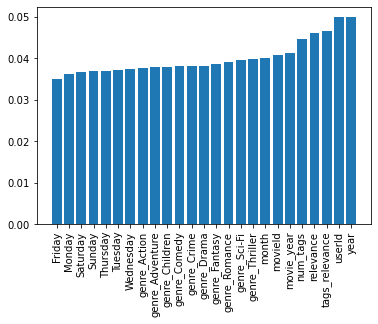

In [29]:
importancia=XBG.feature_importances_

importancia=pd.DataFrame(importancia)

variables=X_test.columns

importancia.index=variables

plt.bar(importancia.index.sort_values(), importancia.loc[:,0].sort_values())

plt.xticks(rotation='vertical')

plt.show()

# Conclussions.

Using binary classifications isn't probable the best option to build a reccommendation system. However, this is a good exercise for training skills when you dont have lot of alerady perprocessed common variables, and you need to be creative building your own.

The size of the data set was an important drawback in order to use grid search for models such as XGBoost. Maybe using a dimensional reduction technique such as **PCA** would be a good option in order to reduce computing time. Doing this probable would allow me to use **kfold cross validation** process. One previous step, in the variable building process, i would try to build a bot ("Or looking for another kaggle data set") to **obatin a wider description of the movie**, and **apply NLP** techniques to buil dummies variables of the relevant words of each movie. 

Also i think handlig the **movieId and userId as ordinal variables** is not a good choice. I definitely think can implement a solution to transform this variables into categorical variables without creating extra columns and without adding computational complexity during the training process. 


Definitely the performance of the model may improve. 50% in the test set is the worst scenario, and definitely proving other models is also an option.